In [1]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf

import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

2023-11-14 13:30:45.168077: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 13:30:45.294512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-14 13:30:47.011705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 13:30:47.023898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-14 13:30:47.024021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        best_params = opt_manager.get_best_params()
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict(test, return_targets=True)
        targets = data_formatter.format_predictions(output_map["targets"])
        p50_forecast = data_formatter.format_predictions(output_map["p50"])
        p90_forecast = data_formatter.format_predictions(output_map["p90"])

        def extract_numerical_data(data):
            """Strips out forecast time and identifier columns."""
            return data[[
                col for col in data.columns
                if col not in {"forecast_time", "identifier"}
            ]]

        p50_loss = utils.numpy_normalised_quantile_loss(
            extract_numerical_data(targets), extract_numerical_data(p50_forecast), 0.5)
        p90_loss = utils.numpy_normalised_quantile_loss(
            extract_numerical_data(targets), extract_numerical_data(p90_forecast), 0.9)

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    print()
    print("Normalised Quantile Loss for Test Data: P50={}, P90={}".format(
        p50_loss.mean(), p90_loss.mean()))
    
    return output_map



In [3]:
dataset_name = 'crypto_day'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()

# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params

Using output folder .


2023-11-13 08:59:56.217961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 08:59:56.218265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 08:59:56.218479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Selecting GPU ID=0
*** Training from defined parameters for crypto_day ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.3
hidden_layer_size: 160
learning_rate: 0.01
minibatch_size: 32
max_gradient_norm: 0.01
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_day/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 160
# learning_rate = 0.01
# max_gradient_norm = 0.01
# minibatch_size = 32
# model_folder = ./saved_models/crypto_day/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 37
# num_encoder_steps = 30
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_VAL

2023-11-13 08:59:56.833981: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_1' id:12 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 08:59:56.835867: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_2' id:13 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

2023-11-13 08:59:57.039889: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/dense_11/bias/Assign' id:423 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/dense_11/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/dense_11/bias, TemporalFusionTransformer/dense_11/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 08:59:57.055897: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_1' id:477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 0>]()}}' w

2023-11-13 08:59:57.514658: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1333 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 08:59:57.531209: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_6/bias/Assign' id:1404 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_6/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_6/bias, TemporalFusionTransformer/time_distributed_6/bias/In

2023-11-13 08:59:58.251703: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_2' id:2396 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 08:59:58.346357: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_29/kernel/Assign' id:2454 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_29/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_29/kernel, TemporalFusionTransforme

2023-11-13 08:59:59.117483: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_1/reduction_indices' id:2794 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_1/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 08:59:59.176950: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_2/reduction_indices' id:3246 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_2/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will

2023-11-13 09:00:00.272714: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_1' id:3909 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 09:00:00.317568: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_2' id:3910 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 37, 7)]              0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 7)]              0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 160)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 160)]                0         ['multiply_2[0][0]']          
 Transform

 tf_op_layer_TemporalFusion  [(None, 37, 160, 1)]         0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 multiply_3 (Multiply)       (None, 160)                  0         ['dense_18[0][0]',            
                                                                     'dense_19[0][0]']            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160, 4)]         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_2[0][0]']     
 9 (TensorFlowOpLayer)                                                                            
          

 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 18 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 19 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_37 (TimeD  (None, 7, 160)               25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/Reshape_1[0][0]']   
                                                                                                  
 time_dist

                                                                                                  
 time_distributed_29 (TimeD  (None, 30, 160)              25760     ['activation_13[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_33 (TimeD  (None, 30, 160)              25760     ['activation_14[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_39 (TimeD  (None, 7, 160)               25760     ['activation_15[0][0]']       
 istributed)                                                                                      
                                                                                                  
 activatio

 activation_5 (Activation)   (None, 160)                  0         ['dense_24[0][0]']            
                                                                                                  
 activation_6 (Activation)   (None, 160)                  0         ['dense_28[0][0]']            
                                                                                                  
 time_distributed_40 (TimeD  (None, 7, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_41 (TimeD  (None, 7, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 dropout_1

                                                                                                  
 dropout_5 (Dropout)         (None, 160)                  0         ['dense_29[0][0]']            
                                                                                                  
 add_13 (Add)                (None, 7, 1)                 0         ['time_distributed_36[0][0]', 
                                                                     'multiply_15[0][0]']         
                                                                                                  
 multiply_16 (Multiply)      (None, 7, 160)               0         ['time_distributed_44[0][0]', 
                                                                     'time_distributed_45[0][0]'] 
                                                                                                  
 activation_8 (Activation)   (None, 30, 6)                0         ['layer_normalization_6[0][0]'
          

                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_6[0][0]']          
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 7, 1, 1)]            0         ['activation_16[0][0]']       
 Transformer/ExpandDims_4 (                                                                       
 TensorFlowOpLayer)                                                                               
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 7, 160, 1)]          0         ['layer_normalization_14[0][0]
 Transformer/stack_5 (Tenso                                         ']                            
 rFlowOpLayer)                                                                                    
          

                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_3[0][0]']    
                                                                                                  
 layer_normalization_3 (Lay  (None, 160)                  320       ['add_3[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_15 (La  (None, 37, 160)              320       ['add_15[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160)]             0         ['layer_normalization_3[0][0]'
 Transform

 orFlowOpLayer)                                                                                   
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 37)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/diag (Tens                                         ansformer/eye/ones[0][0]']    
 orFlowOpLayer)                                                                                   
                                                                                                  
 dense_80 (Dense)            (None, 37, 160)              25600     ['layer_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 dense_81 (Dense)            (None, 37, 160)              25600     ['layer_normalization_16[0][0]
          

 yerNormalization)                                                                                
                                                                                                  
 time_distributed_59 (TimeD  (None, 37, 160)              25760     ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 time_distributed_60 (TimeD  (None, 37, 160)              25760     ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 multiply_22 (Multiply)      (None, 37, 160)              0         ['time_distributed_59[0][0]', 
                                                                     'time_distributed_60[0][0]'] 
          

2023-11-13 09:00:01.078384: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_19/beta/Assign' id:4500 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_19/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_19/beta, TemporalFusionTransformer/layer_normalization_19/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 864 samples, validate on 101 samples
Epoch 1/100


2023-11-13 09:00:03.175928: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4692 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 09:00:03.504330: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/TemporalFusionTransformer/layer_normalization/gamma/v/Assign' id:8693 op device:{requested: '', assigned: ''} def:{{{node training/Adam/TemporalFusionTransformer/layer_normalization/gamma/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/TemporalFusionTransform

800/864 [==========================>...] - ETA: 0s - loss: 1.1984

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-13 09:00:06.575267: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4692 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


864/864 [==============================] - 5s 5ms/sample - loss: 1.1335 - val_loss: 0.5197
Epoch 2/100
864/864 [==============================] - 1s 830us/sample - loss: 0.2761 - val_loss: 0.0871
Epoch 3/100
864/864 [==============================] - 1s 715us/sample - loss: 0.1763 - val_loss: 0.1066
Epoch 4/100
864/864 [==============================] - 1s 708us/sample - loss: 0.1593 - val_loss: 0.1178
Epoch 5/100
864/864 [==============================] - 1s 698us/sample - loss: 0.1826 - val_loss: 0.1291
Epoch 6/100
864/864 [==============================] - 1s 812us/sample - loss: 0.1664 - val_loss: 0.0801
Epoch 7/100
864/864 [==============================] - 1s 727us/sample - loss: 0.1584 - val_loss: 0.0915
Epoch 8/100
864/864 [==============================] - 1s 849us/sample - loss: 0.1499 - val_loss: 0.0471
Epoch 9/100
864/864 [==============================] - 1s 714us/sample - loss: 0.1564 - val_loss: 0.1454
Epoch 10/100
864/864 [==============================] - 1s 679us/samp

2023-11-13 09:00:16.198237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 09:00:16.198572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 09:00:16.198758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-13 09:00:16.404917: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/dense_10/kernel/Assign' id:395 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/dense_10/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/dense_10/kernel, TemporalFusionTransformer/dense_10/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 09:00:16.423337: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_1' id:477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape:

2023-11-13 09:00:16.899565: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_11/stack_2' id:292 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_11/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 09:00:16.929366: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1333 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no e

2023-11-13 09:00:17.837869: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_10/gamma/Assign' id:2351 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_10/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_10/gamma, TemporalFusionTransformer/layer_normalization_10/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 09:00:17.883097: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_1' id:2395 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT3

2023-11-13 09:00:18.773423: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_43/bias/Assign' id:3104 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_43/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_43/bias, TemporalFusionTransformer/time_distributed_43/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 09:00:18.833701: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_1/reduction_indices' id:2794 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_1/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<t

2023-11-13 09:00:19.794614: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/concat/axis' id:3919 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/concat/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-13 09:00:19.841733: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_22/stack' id:3913 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_22/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 37, 7)]              0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 7)]              0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 160)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 160)]                0         ['multiply_2[0][0]']          
 Transform

 tf_op_layer_TemporalFusion  [(None, 37, 160, 1)]         0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 multiply_3 (Multiply)       (None, 160)                  0         ['dense_18[0][0]',            
                                                                     'dense_19[0][0]']            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160, 4)]         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_2[0][0]']     
 9 (TensorFlowOpLayer)                                                                            
          

 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 18 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 19 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_37 (TimeD  (None, 7, 160)               25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/Reshape_1[0][0]']   
                                                                                                  
 time_dist

                                                                                                  
 time_distributed_29 (TimeD  (None, 30, 160)              25760     ['activation_13[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_33 (TimeD  (None, 30, 160)              25760     ['activation_14[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_39 (TimeD  (None, 7, 160)               25760     ['activation_15[0][0]']       
 istributed)                                                                                      
                                                                                                  
 activatio

 activation_5 (Activation)   (None, 160)                  0         ['dense_24[0][0]']            
                                                                                                  
 activation_6 (Activation)   (None, 160)                  0         ['dense_28[0][0]']            
                                                                                                  
 time_distributed_40 (TimeD  (None, 7, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_41 (TimeD  (None, 7, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 dropout_1

                                                                                                  
 dropout_5 (Dropout)         (None, 160)                  0         ['dense_29[0][0]']            
                                                                                                  
 add_13 (Add)                (None, 7, 1)                 0         ['time_distributed_36[0][0]', 
                                                                     'multiply_15[0][0]']         
                                                                                                  
 multiply_16 (Multiply)      (None, 7, 160)               0         ['time_distributed_44[0][0]', 
                                                                     'time_distributed_45[0][0]'] 
                                                                                                  
 activation_8 (Activation)   (None, 30, 6)                0         ['layer_normalization_6[0][0]'
          

                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_6[0][0]']          
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 7, 1, 1)]            0         ['activation_16[0][0]']       
 Transformer/ExpandDims_4 (                                                                       
 TensorFlowOpLayer)                                                                               
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 7, 160, 1)]          0         ['layer_normalization_14[0][0]
 Transformer/stack_5 (Tenso                                         ']                            
 rFlowOpLayer)                                                                                    
          

                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_3[0][0]']    
                                                                                                  
 layer_normalization_3 (Lay  (None, 160)                  320       ['add_3[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_15 (La  (None, 37, 160)              320       ['add_15[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160)]             0         ['layer_normalization_3[0][0]'
 Transform

 orFlowOpLayer)                                                                                   
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 37, 37)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/diag (Tens                                         ansformer/eye/ones[0][0]']    
 orFlowOpLayer)                                                                                   
                                                                                                  
 dense_80 (Dense)            (None, 37, 160)              25600     ['layer_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 dense_81 (Dense)            (None, 37, 160)              25600     ['layer_normalization_16[0][0]
          

 yerNormalization)                                                                                
                                                                                                  
 time_distributed_59 (TimeD  (None, 37, 160)              25760     ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 time_distributed_60 (TimeD  (None, 37, 160)              25760     ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 multiply_22 (Multiply)      (None, 37, 160)              0         ['time_distributed_59[0][0]', 
                                                                     'time_distributed_60[0][0]'] 
          

[[-0.12843372 -0.17356864  0.08178376 ...  0.12299306  0.10229474
   0.06226335]
 [-0.1627238  -0.07098659 -0.04678803 ... -0.02346383 -0.03257582
   0.0746802 ]
 [-0.12625651 -0.00740541 -0.15337855 ...  0.03068466  0.07080433
  -0.18432961]
 ...
 [-0.05617442 -0.08621308  0.07956044 ...  0.18306406  0.0144252
   0.04550549]
 [-0.03873612  0.05293051  0.14531967 ...  0.12904254  0.00990588
   0.06047057]
 [ 0.02309817 -0.15210998 -0.01261926 ... -0.04715993 -0.01563977
  -0.18400775]]
tensor: TemporalFusionTransformer/dense_17/bias (float32) [160]
[-0.07840329  0.03189548  0.08423995  0.03984069 -0.03183189  0.01682506
  0.08450997 -0.08548963 -0.08031268 -0.08481318  0.01859011  0.08537813
 -0.07463464 -0.08018305 -0.07848214  0.02264385  0.08163452  0.07474006
  0.08420526  0.05934924 -0.05694638 -0.07622293 -0.00092654  0.08379394
 -0.07684801 -0.04161498  0.02754712 -0.05385702 -0.07932962 -0.07379995
 -0.05654819 -0.07019015  0.06883721  0.0803021  -0.06823889 -0.07574213
  0.069

[[ 0.22810978 -0.05740309  0.05977236 ... -0.03837588 -0.14454323
   0.01247193]
 [ 0.10522445  0.12267268  0.1581711  ... -0.105105    0.00947761
   0.17441143]
 [ 0.08243441  0.02880952  0.21894456 ... -0.08574926 -0.08505239
  -0.01760616]
 ...
 [-0.01127539 -0.08653624  0.19604008 ... -0.02105869  0.03647437
   0.0847427 ]
 [-0.05095067  0.24133426  0.03262844 ...  0.152768   -0.07615739
   0.01679507]
 [ 0.04203811 -0.06333564 -0.01871546 ... -0.05143705  0.12268168
   0.02000508]]
tensor: TemporalFusionTransformer/dense_30/bias (float32) [160]
[ 0.03982847 -0.07968965  0.0702319   0.05671973  0.07971233  0.06814757
  0.07134125 -0.04776346 -0.06022935  0.06613206 -0.00935753 -0.06579984
  0.03113267 -0.02799032  0.07262269 -0.06116744 -0.05594371 -0.03388878
 -0.0878533   0.05889501  0.06030231  0.08135411  0.06147563  0.00049781
  0.05350774 -0.06176167 -0.06667271  0.05325134 -0.05005315 -0.03776119
  0.07529968 -0.08676427 -0.07483768 -0.0813845  -0.08219424  0.08304959
 -0.04

[[ 0.07725547 -0.04038101  0.03222714 ... -0.08827288  0.00513472
   0.01252154]
 [-0.07448529 -0.17404373  0.13361724 ... -0.18492606  0.12285408
   0.03424917]
 [ 0.02618868  0.02592316 -0.12220266 ... -0.08723524 -0.05301276
   0.06926964]
 ...
 [ 0.1523047   0.00881302 -0.1271665  ...  0.2037991   0.05054853
   0.03137329]
 [-0.11110658  0.00248215  0.219983   ... -0.17648046 -0.08596791
  -0.05331783]
 [ 0.18997076  0.01045013 -0.04665214 ... -0.06583848  0.01258224
   0.14209351]]
tensor: TemporalFusionTransformer/dense_8/bias (float32) [160]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

[1.080259   0.9806133  0.93694633 1.0559932  0.97966623 0.99985754
 0.9450149  0.94840574 1.0121456  1.0298498  1.0202588  1.0941473
 0.9101498  0.9810825  1.0673087  0.9695942  0.94328696 1.0128442
 0.9770169  1.0828617  1.0453374  0.95099664 0.9317216  1.0259753
 1.0084587  1.0727382  0.9691199  0.8911263  0.99801695 0.9970021
 0.9528404  0.92775625 0.92025506 0.98746294 1.035332   1.0902103
 0.98697513 1.0541879  1.0672959  0.93341875 0.9943987  1.1063744
 1.0364825  0.91440666 0.92207205 0.967158   1.0780765  1.0730164
 1.1200727  0.8834728  0.94247246 1.0207913  0.99235    1.0256411
 0.8513179  0.8998138  0.9789676  1.0247133  0.97861594 0.9367724
 0.9324876  1.0292622  1.0855355  1.1265903  0.9639266  1.0439464
 1.0401171  0.9978668  0.9150825  0.9326681  0.9286701  0.98808885
 1.0613298  0.98133075 1.0238283  1.0619195  1.046634   1.0435458
 0.98110247 0.943884   0.9248874  0.98320264 1.009783   1.1827972
 0.94417125 1.1390195  1.0860823  0.9339687  1.034609   0.9397177
 1.08460

[[ 0.0045063  -0.06735593  0.23245123 -0.12478302  0.02520884 -0.05954512]
 [-0.00568501  0.01659197  0.06877082 -0.18677378  0.15665917 -0.1465948 ]
 [ 0.09795006 -0.09580006  0.138303   -0.17020889  0.0358813  -0.05809298]
 [-0.06557626 -0.00489999  0.05177752  0.20555449  0.04168769  0.01419748]
 [ 0.17160335 -0.00897069 -0.14368764  0.22308308 -0.15266347 -0.24663062]
 [-0.28103834 -0.13998544  0.25384632 -0.17230755  0.00231191  0.09335406]
 [-0.09565922  0.10636415 -0.18637423  0.09064801  0.21323845 -0.02913043]
 [-0.03120468 -0.08985515 -0.24334325  0.08718129 -0.01828182 -0.09660133]
 [ 0.10581996 -0.118383   -0.13064964  0.16620632  0.18504183 -0.14088656]
 [ 0.22264762 -0.03266302 -0.13233517  0.14652258  0.01154564 -0.12628539]
 [ 0.01957372 -0.04400365  0.22699012 -0.20137224 -0.17071074  0.05116457]
 [-0.2573971   0.03791361  0.17576487 -0.17308103  0.14184524 -0.08256693]
 [-0.00580388  0.0559491   0.2486455   0.05196356 -0.1864914   0.18519723]
 [-0.04200378 -0.06957912

[[-0.04208615  0.02117854  0.09931678 -0.09287453  0.10903469 -0.08692148]
 [-0.02534717 -0.0580961   0.10836343 -0.07583585  0.16376212 -0.00927358]
 [-0.05905069 -0.08049969 -0.01493922  0.05762956 -0.25594145  0.03193455]
 [ 0.2279354  -0.0889988  -0.1526763   0.12911928 -0.28255987 -0.07392709]
 [ 0.12127081  0.08742613 -0.07642736  0.08214504 -0.09108949  0.04273487]
 [-0.2701496  -0.02717324  0.09026846  0.04626899  0.06725857 -0.22894534]
 [ 0.12274819  0.17380849 -0.24286504 -0.08468886 -0.15118368  0.09278434]
 [ 0.06538068 -0.04408305  0.07413848 -0.27981687  0.19544244  0.11005481]
 [ 0.20518331  0.2617672  -0.07128127  0.04590584 -0.03953079  0.08972536]
 [ 0.18426834  0.04060279 -0.12162977  0.0295973   0.12976414  0.20847958]
 [ 0.08830196  0.09028641  0.1368957  -0.2354411  -0.07799318 -0.01580628]
 [ 0.09121682 -0.19134603  0.1521722   0.23654677 -0.1690968  -0.03384288]
 [-0.07686869  0.11319975  0.1443368   0.02346664  0.05438663  0.06169125]
 [-0.22832261 -0.17790629

[[ 0.3136445   0.00148242 -0.04548489 ...  0.02190175 -0.00697963
  -0.07218922]
 [-0.22579543 -0.02240646  0.10658457 ... -0.12840547  0.00681223
   0.01238892]
 [-0.15024514  0.07040744  0.00409986 ... -0.04339594 -0.16466503
  -0.04901618]
 ...
 [-0.14670964 -0.14584327 -0.16926637 ... -0.08120025  0.02723063
  -0.0167404 ]
 [ 0.04039293  0.0215373   0.06815978 ...  0.10722115  0.05338803
   0.00128996]
 [-0.25013953 -0.08611853  0.10231831 ... -0.14623798  0.05187428
   0.18176247]]
tensor: TemporalFusionTransformer/time_distributed_21/bias (float32) [160]
[-0.03524094 -0.01966223  0.00541561 -0.08265792  0.07329658 -0.087991
 -0.02432595 -0.09528191  0.14041583  0.02202658  0.1046138   0.00232535
 -0.15155123  0.06398711 -0.07961439  0.15841982 -0.08819558 -0.01383929
  0.00367599 -0.06335092 -0.01432466 -0.05563115 -0.09546304 -0.04058414
  0.01283761 -0.09846272 -0.03499149 -0.05371315 -0.04648107  0.1658311
  0.01689556  0.03506547 -0.06254165  0.00082064 -0.01813252 -0.0682545

[[ 0.18061946  0.12451363  0.07308263 ...  0.1303361   0.10325641
   0.12555791]
 [ 0.1321086  -0.00057945 -0.04422862 ...  0.02970887  0.08451243
  -0.02533853]
 [-0.09545846 -0.19108048 -0.07110721 ...  0.23508182  0.09093315
  -0.21156584]
 ...
 [ 0.14931871  0.02216491  0.03962478 ... -0.02024599  0.10833727
   0.14877649]
 [-0.13578646 -0.02746763 -0.01314799 ... -0.07500088  0.03236468
  -0.06562758]
 [ 0.0193876   0.04834133 -0.09468523 ... -0.19324659 -0.05066814
   0.02629941]]
tensor: TemporalFusionTransformer/time_distributed_24/bias (float32) [160]
[ 0.01918007 -0.10634698  0.10932089 -0.05854409 -0.0205001   0.07120833
 -0.12901157  0.04581704 -0.06950731 -0.04555053 -0.08570803 -0.11252065
  0.02608963  0.04167272  0.06377118  0.09375572 -0.09905515 -0.11405659
 -0.01952686 -0.01017209 -0.05037298  0.11378039 -0.0214371   0.07669386
 -0.06490453 -0.11294477 -0.08586584  0.03418461  0.029676   -0.04699623
 -0.03335647  0.00221867 -0.10016859 -0.02342126 -0.0784207   0.0669

INFO:tensorflow:Restoring parameters from ./saved_models/crypto_day/fixed/TemporalFusionTransformer.ckpt


2023-11-13 09:00:20.752675: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_61/kernel/Assign' id:4593 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_61/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_61/kernel, TemporalFusionTransformer/time_distributed_61/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Done.
Computing best validation loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-13 09:00:21.097237: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4692 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Computing test loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-13 09:00:21.431521: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_61/Reshape_1' id:4607 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_61/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](TemporalFusionTransformer/time_distributed_61/dense_91/BiasAdd, TemporalFusionTransformer/time_distributed_61/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training completed @ 2023-11-13 09:00:21.785937
Best validation loss = 0.05510705737120444
Params:
dropout_rate  =  0.3
hidden_layer_size  =  160
learning_rate  =  0.01
max_gradient_norm  =  0.01
minibatch_size  =  32
model_folder  =  ./saved_models/crypto_day/fixed
num_heads  =  1
stack_size  =  1
total_time_steps  =  37
num_encoder_steps  =  30
num_epochs  =  100
early_stopping_patience  =  5
multiprocessing_workers  =  5
column_definition  =  [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('btc_low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('btc_close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INP

In [4]:
output_map

{'p10':    forecast_time identifier       t+0       t+1       t+2       t+3       t+4  \
 0     2023-09-19   BTC_USDT -0.697721 -0.699169 -0.731755 -0.730640 -0.731181   
 1     2023-09-20   BTC_USDT -0.701249 -0.732580 -0.730869 -0.730888 -0.743286   
 2     2023-09-21   BTC_USDT -0.736359 -0.731817 -0.731229 -0.743416 -0.741316   
 3     2023-09-22   BTC_USDT -0.735860 -0.732348 -0.743807 -0.741468 -0.744458   
 4     2023-09-23   BTC_USDT -0.736375 -0.744866 -0.741806 -0.744579 -0.738917   
 5     2023-09-24   BTC_USDT -0.749264 -0.742920 -0.744931 -0.739054 -0.701327   
 6     2023-09-25   BTC_USDT -0.747345 -0.746065 -0.739427 -0.701477 -0.708657   
 7     2023-09-26   BTC_USDT -0.750538 -0.740578 -0.702008 -0.708710 -0.705696   
 8     2023-09-27   BTC_USDT -0.744893 -0.703236 -0.709324 -0.705656 -0.666386   
 9     2023-09-28   BTC_USDT -0.705856 -0.710232 -0.705621 -0.666713 -0.686550   
 10    2023-09-29   BTC_USDT -0.712999 -0.706324 -0.666782 -0.686783 -0.689197   
 11    20

In [11]:
targets = formatter.format_predictions(output_map["targets"])

real_close = pd.DataFrame(targets['forecast_time'])
real_close["real_close"] = targets['t+0']

p10_forecast = formatter.format_predictions(output_map["p10"])
p10_forecast_close = p10_forecast['t+0']

p50_forecast = formatter.format_predictions(output_map["p50"])
p50_forecast_close = p50_forecast['t+0']

p90_forecast = formatter.format_predictions(output_map["p90"])
p90_forecast_close = p90_forecast['t+0']

real_and_pred_results = real_close
real_and_pred_results['p10_forecast_close'] = p10_forecast_close
real_and_pred_results['p50_forecast_close'] = p50_forecast_close
real_and_pred_results['p90_forecast_close'] = p90_forecast_close
real_and_pred_results.set_index(['forecast_time'])

,real_close,p10_forecast_close,p50_forecast_close,p90_forecast_close
forecast_time,,,,
2023-09-19,26573.81,25130.216797,26852.156250,27792.400391
2023-09-20,26578.04,25080.906250,26796.019531,27723.414062
2023-09-21,26567.19,24590.167969,26190.746094,27032.878906
2023-09-22,26246.48,24597.138672,26200.000000,27043.582031
2023-09-23,26303.68,24589.939453,26191.789062,27033.677734
2023-09-24,26218.78,24409.792969,26001.896484,26800.564453
2023-09-25,26367.41,24436.605469,26030.537109,26836.158203
2023-09-26,27017.99,24391.984375,25982.656250,26776.435547
2023-09-27,26906.87,24470.876953,26065.236328,26879.310547


<Axes: >

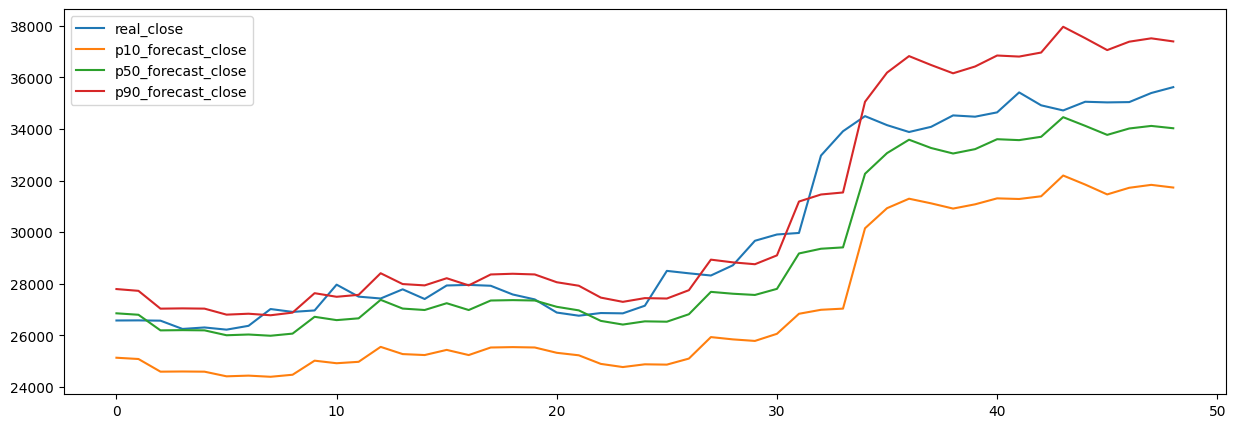

In [10]:
real_and_pred_results.plot(figsize=(15,5))